In [1]:
import sys
sys.path.insert(0, '../train')
from helper import *
%matplotlib inline

#Wireless Parameters
N_t = 64
N_r = 16
latent_dim = 65

In [2]:
class Discriminator(nn.Module):
    def __init__(self,mb_size):
        super(Discriminator,self).__init__()
        self.embedding = nn.Embedding(2,10)
        self.linear_e = nn.Linear(10,N_t*N_r)
        self.view_e = View([mb_size,1,N_t,N_r])
        self.concat = Concatenate(1)
        self.conv2d_1 = Conv2d(3,16,3,stride=2)
        self.leakyrelu = nn.LeakyReLU(0.2,inplace=True)
        self.dropout = nn.Dropout(0.25)
        self.zeropad = nn.ZeroPad2d(padding=(0,1,0,1))
        self.conv2d_2 = Conv2d(16,32,3,stride=2)
        self.conv2d_3 = Conv2d(32,64,3,stride=2)
        self.conv2d_4 = Conv2d(64,128,3,stride=1)
        self.flatten = nn.Flatten()
        self.linear_d = nn.Linear(3456,1)
        
    def forward(self,x,c):
        c_e = self.embedding(c)
        c_l = self.linear_e(c_e)
        c_v = self.view_e(c_l)
        
        x_c = self.concat([x,c_v])
        x_c_1 = self.conv2d_1(x_c)
        x_c_1 = self.leakyrelu(x_c_1)
        x_c_1 = self.dropout(x_c_1)
        x_c_2 = self.conv2d_2(x_c_1)
        x_c_2 = self.zeropad(x_c_2)
        x_c_2 = self.leakyrelu(x_c_2)
        x_c_2 = self.dropout(x_c_2)
        x_c_3 = self.conv2d_3(x_c_2)
        x_c_3 = self.leakyrelu(x_c_3)
        x_c_3 = self.dropout(x_c_3)
        x_c_4 = self.conv2d_4(x_c_3)
        x_c_4 = self.leakyrelu(x_c_4)
        x_c_4 = self.dropout(x_c_4)
        x_c_4 = self.flatten(x_c_4)
        output = self.linear_d(x_c_4)
        
        return output

D = Discriminator(1).type(dtype)

In [3]:
length = int(N_t/4)
breadth = int(N_r/4)
class Generator(nn.Module):
    def __init__(self,mb_size):
        super(Generator,self).__init__()
        self.mb_size = mb_size
        self.embedding = nn.Embedding(2,10)
        self.linear_e = nn.Linear(10,length*breadth)
        self.view_e = View([1,1,length,breadth])
        self.linear_g1 = nn.Linear(latent_dim, 127*length*breadth)
        self.relu = nn.ReLU()
        self.view_g = View([1,127,length,breadth])
        self.upsample_g = nn.Upsample(scale_factor=2)
        self.batchnorm_g1 = nn.BatchNorm2d(128,momentum=0.8)
        self.batchnorm_g2 = nn.BatchNorm2d(128,momentum=0.8)
        self.batchnorm_g3 = nn.BatchNorm2d(128,momentum=0.8)
        self.conv2d_g1 = Conv2d(128,128,4,bias=False)
        self.conv2d_g2 = Conv2d(128,128,4,bias=False)
        self.conv2d_g4 = Conv2d(128,128,4,bias=False)
        self.conv2d_g3 = Conv2d(128,2,4,bias=False)
        self.concat = Concatenate(1)
        
    def forward(self,z,c):
        c_e = self.embedding(c)
        c_l = self.linear_e(c_e)
        c_v = self.view_e(c_l)
        
        z1 = self.linear_g1(z)
        z1 = self.relu(z1)
        z1_v = self.view_g(z1)
        
        z_c = self.concat([z1_v,c_v])
        z_c_1 = self.upsample_g(z_c)
        z_c_1 = self.conv2d_g1(z_c_1)
        z_c_1 = self.batchnorm_g1(z_c_1)
        z_c_1 = self.relu(z_c_1)
        z_c_2 = self.upsample_g(z_c_1)
        z_c_2 = self.conv2d_g2(z_c_2)
        z_c_2 = self.batchnorm_g2(z_c_2)
        z_c_2 = self.relu(z_c_2)
        z_c_2 = self.conv2d_g4(z_c_2)
        z_c_2 = self.batchnorm_g3(z_c_2)
        z_c_2 = self.relu(z_c_2)
        output = self.conv2d_g3(z_c_2)
        
        return output

G_test = Generator(1).type(dtype)

In [4]:
import copy
dft_basis = sio.loadmat("../../data/dft_basis.mat")
A_T = dft_basis['A1']/np.sqrt(N_t)
A_R = dft_basis['A2']/np.sqrt(N_r)

def fft_op(H_extracted):
    for i in range(H_extracted.shape[0]):
        H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))
    return H_extracted
    
H_org_A = sio.loadmat("../../data/H_16x64_MIMO_CDL_A_ULA_clean.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_extracted_A = fft_op(H_extracted_A)
H_org_B = sio.loadmat("../../data/H_16x64_MIMO_CDL_B_ULA_clean.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_extracted_B = fft_op(H_extracted_B)
H_org_C = sio.loadmat("../../data/H_16x64_MIMO_CDL_C_ULA_clean.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_extracted_C = fft_op(H_extracted_C)
H_org_D = sio.loadmat("../../data/H_16x64_MIMO_CDL_D_ULA_clean.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_extracted_D = fft_op(H_extracted_D)
H_org_E = sio.loadmat("../../data/H_16x64_MIMO_CDL_E_ULA_clean.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))
H_extracted_E = fft_op(H_extracted_E)

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)

img_np_real = np.real(H_extracted)
img_np_imag = np.imag(H_extracted)
mu_real = np.mean(img_np_real,axis=0)
mu_imag = np.mean(img_np_imag,axis=0)
std_real = np.std(img_np_real,axis=0)
std_imag = np.std(img_np_imag,axis=0)

In [5]:
A_T_R = np.kron(A_T.conj(),A_R)
A_R_T = np.kron(np.transpose(A_T),np.matrix(A_R).getH())
A_T_R_real = dtype(np.real(A_T_R))
A_T_R_imag = dtype(np.imag(A_T_R))

In [6]:
H_org_A = sio.loadmat("../../data/H_16x64_MIMO_CDL_A_ULA_test.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_org_B = sio.loadmat("../../data/H_16x64_MIMO_CDL_B_ULA_test.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_org_C = sio.loadmat("../../data/H_16x64_MIMO_CDL_C_ULA_test.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_org_D = sio.loadmat("../../data/H_16x64_MIMO_CDL_D_ULA_test.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_org_E = sio.loadmat("../../data/H_16x64_MIMO_CDL_E_ULA_test.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)
H_extracted = fft_op(H_extracted)
H_ex = np.concatenate([H_ex_A,H_ex_B,H_ex_C,H_ex_D,H_ex_E],axis=2)

size = int(H_extracted.shape[0]/5)
CDL_NLOS = np.zeros((3*size,1))
CDL_LOS = np.ones((2*size,1))
CDL = np.concatenate((CDL_NLOS,CDL_LOS),axis=0)

In [7]:
ntest = 51           
nrepeat = 5 #Different noise realizations
alpha = 0.4
N_p = int(alpha*N_t)
N_s = N_r
N_rx_rf = N_r
Nbit_t = 6
Nbit_r = 2
angles_t = np.linspace(0,2*np.pi,2**Nbit_t,endpoint=False)
angles_r = np.linspace(0,2*np.pi,2**Nbit_r,endpoint=False)
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_rx_rf):
    angle_index = np.random.choice(len(angles_r),(N_r,N_rx_rf))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

eye_N_p = np.identity(N_p)

pilot_sequence_ind = np.random.randint(0,4,size=(N_s,N_p))
symbols = qpsk_constellation[pilot_sequence_ind]
precoder_training = training_precoder(N_t,N_s)
W = training_combiner(N_r,N_s)
tx = np.transpose(np.matmul(precoder_training,symbols))
A = np.kron(np.matmul(symbols.T,precoder_training.T),W)
A_mat = np.matmul(np.linalg.pinv(np.kron(tx,W)),np.kron(eye_N_p,W))

A_real = dtype(np.real(A))
A_imag = dtype(np.imag(A))
identity = np.identity(N_r)
lambda_reg = 1e-3

In [ ]:
freq_1 = 400
freq_2 = 4000
model_vec = np.concatenate([np.arange(0,4400,freq_1),np.arange(8000,101000,freq_2)])
SNR_vec = range(15,20,5)
nmse_by_channel_CWGAN = np.zeros((len(SNR_vec),len(model_vec),ntest))

ct = 0
model_ct = 0
ct += 1

for model in model_vec:
    model_ct += 1
    if model < 100000:
        G_test.load_state_dict(torch.load('../../results/cwgan/generator%d.pt'%model)) 
    else:
        G_test.load_state_dict(torch.load('../../results/cwgan/generator_CDL_ABCDE_ld_35_FFT.pt'))
    G_test.eval()
    for SNR in SNR_vec:
        for i in range(nrepeat):
            for ind in range(0,H_ex.shape[2],5):
                vec_H_single = np.reshape(H_ex[:,:,ind].flatten('F'),[N_r*N_t,1])
                signal = np.matmul(H_ex[:,:,ind],np.matmul(precoder_training,symbols))
                E_s = np.multiply(signal,np.conj(signal))
                noise_matrix = (1/np.sqrt(2))*(np.random.randn(N_r,N_p)+1j*np.random.randn(N_r,N_p))
                vec_y = np.zeros((N_s*N_p,1,1),dtype='complex64')
                std_dev = (1/(10**(SNR/20)))*np.sqrt(E_s)
                rx_signal = signal + np.multiply(std_dev,noise_matrix)
                rx_signal = np.matmul(W,rx_signal)
                vec_y[:,0,0] = rx_signal.flatten('F') 
                vec_y_real = dtype(np.real(vec_y[:,:,0]))
                vec_y_imag = dtype(np.imag(vec_y[:,:,0]))
                def gen_output(x,c):
                    pred = G_test(x,c)
                    pred[0,0,:,:] = dtype(std_real)*pred[0,0,:,:] + dtype(mu_real)
                    pred[0,1,:,:] = dtype(std_imag)*pred[0,1,:,:] + dtype(mu_imag)
                    pred_real = torch.mm(A_T_R_real,pred[0,0,:,:].view(N_t*N_r,-1)) - torch.mm(A_T_R_imag,pred[0,1,:,:].view(N_t*N_r,-1))
                    pred_imag = torch.mm(A_T_R_real,pred[0,1,:,:].view(N_t*N_r,-1)) + torch.mm(A_T_R_imag,pred[0,0,:,:].view(N_t*N_r,-1))
                    diff_real = vec_y_real - torch.mm(A_real,pred_real) + torch.mm(A_imag,pred_imag)
                    diff_imag = vec_y_imag - torch.mm(A_real,pred_imag) - torch.mm(A_imag,pred_real)
                    diff = torch.norm(diff_real)**2 + torch.norm(diff_imag)**2
                    return diff + lambda_reg*torch.norm(x)**2
                x = Variable(torch.randn(1, latent_dim)).type(dtype)
                c = torch.from_numpy(np.array([CDL[ind,0]])).long().type(dtype_long)
                x.requires_grad = True
                learning_rate = 1e-1
                optimizer = torch.optim.Adam([x], lr=learning_rate)
                for a in range(100):
                    optimizer.zero_grad()
                    loss = gen_output(x,c)
                    loss.backward()
                    optimizer.step()
                gen_imgs = G_test(x,c).data.cpu().numpy()
                gen_imgs[0,0,:,:] = std_real*gen_imgs[0,0,:,:] + mu_real
                gen_imgs[0,1,:,:] = std_imag*gen_imgs[0,1,:,:] + mu_imag
                gen_imgs_complex = gen_imgs[0,0,:,:] + 1j*gen_imgs[0,1,:,:]
                gen_imgs_complex = np.matmul(A_T_R,np.reshape(gen_imgs_complex,[N_t*N_r,1]))
                nmse_by_channel_CWGAN[ct-1,model_ct-1,int(ind/5)] = nmse_by_channel_CWGAN[ct-1,model_ct-1,int(ind/5)] + (np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2
                print(ind,(np.linalg.norm(gen_imgs_complex - vec_H_single)/np.linalg.norm(vec_H_single))**2)
nmse_by_channel_CWGAN = nmse_by_channel_CWGAN/(nrepeat)

In [358]:
nmse_ABCDE_CWGAN = np.zeros((5,len(model_vec)))
nmse_ABCDE_CWGAN[0,:] = np.mean(nmse_by_channel_CWGAN[:,0,0:11],axis=1)
nmse_ABCDE_CWGAN[1,:] = np.mean(nmse_by_channel_CWGAN[:,0,11:21],axis=1)
nmse_ABCDE_CWGAN[2,:] = np.mean(nmse_by_channel_CWGAN[:,0,21:31],axis=1)
nmse_ABCDE_CWGAN[3,:] = np.mean(nmse_by_channel_CWGAN[:,0,31:41],axis=1)
nmse_ABCDE_CWGAN[4,:] = np.mean(nmse_by_channel_CWGAN[:,0,41:],axis=1)

In [ ]:
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[0,:]),'p-',label='CDL-A')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[1,:]),'d-',label='CDL-B')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[2,:]),'v-',label='CDL-C')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[3,:]),'s-',label='CDL-D')
plt.plot(model_vec,10*np.log10(nmse_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[4,:]),'o-',label='CDL-E')
plt.plot(model_vec,10*np.log10(np.mean(nmse_by_channel_CWGAN_snr_20_ld_65_noGP_v2,axis=2)).T[:,0],'*-',label='All')
plt.legend(loc = (0.4,0.2))
plt.xlabel('Training Iterations')
plt.ylabel('NMSE (in dB)')
plt.ylim([-10.5,1.3])
plt.grid(ls=':')
plt.savefig('../../results/CWGAN.pdf',dpi=5000)

In [273]:
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP = np.zeros((5,len(SNR_vec)))
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[0,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,0:11],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[1,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,11:21],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[2,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,21:31],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[3,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,31:41],axis=1)
nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP[4,:] = np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP[:,0,41:],axis=1)

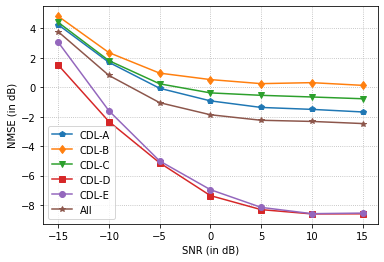

In [359]:
SNR_vec = range(-15,20,5)
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[0,:]),'p-',label='CDL-A')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[1,:]),'d-',label='CDL-B')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[2,:]),'v-',label='CDL-C')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[3,:]),'s-',label='CDL-D')
plt.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[4,:]),'o-',label='CDL-E')
plt.plot(SNR_vec,10*np.log10(np.mean(nmse_SNR_by_channel_CWGAN_snr_30_ld_65_noGP_v2,axis=2)),'*-',label='All')
plt.legend(loc='lower left')
plt.xlabel('SNR (in dB)')
plt.ylabel('NMSE (in dB)')
plt.grid(ls=':')

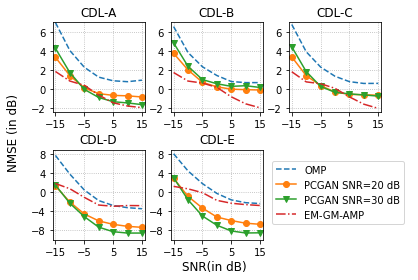

In [409]:
nmse_ABCDE_omp = np.load('../../results/wgan_gp/plot_data/nmse_omp.npy')
nmse_ABCDE_emgmamp = sio.loadmat('../../results/wgan_gp/plot_data/nmse_emgmamp.mat')['nmse_emgmamp_3']
fig = plt.figure()
ax1 = plt.subplot2grid(shape=(7,54), loc=(0,0), colspan=15, rowspan=3)
ax2 = plt.subplot2grid((7,54), (0,19), colspan=15, rowspan=3)
ax3 = plt.subplot2grid((7,54), (0,38), colspan=15, rowspan=3)
ax4 = plt.subplot2grid((7,54), (4,0), colspan=15, rowspan=3)
ax5 = plt.subplot2grid((7,54), (4,19), colspan=15, rowspan=3)

ax1.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[0,:]),'--',label='OMP',color='#1f77b4')
ax1.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[0,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax1.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[0,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax1.plot(SNR_vec,nmse_ABCDE_emgmamp[0,:],'-.',label='EM-GM-AMP',color='#d62728')
ax1.grid(ls=':')
ax1.set_xlim([-16,16]); ax1.set_ylim([-2.5,7]); ax1.set_xticks((-15,-5,5,15)); ax1.set_yticks([-2,0,2,4,6])

ax2.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[1,:]),'--',label='OMP',color='#1f77b4')
ax2.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[1,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax2.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[1,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax2.plot(SNR_vec,nmse_ABCDE_emgmamp[1,:],'-.',label='EM-GM-AMP',color='#d62728')
ax2.grid(ls=':')
ax2.set_xlim([-16,16]); ax2.set_ylim([-2.5,7]); ax2.set_xticks((-15,-5,5,15)); ax2.set_yticks([-2,0,2,4,6])

ax3.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[2,:]),'--',label='OMP',color='#1f77b4')
ax3.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[2,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax3.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[2,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax3.plot(SNR_vec,nmse_ABCDE_emgmamp[2,:],'-.',label='EM-GM-AMP',color='#d62728')
ax3.grid(ls=':')
ax3.set_xlim([-16,16]); ax3.set_ylim([-2.5,7]); ax3.set_xticks((-15,-5,5,15)); ax3.set_yticks([-2,0,2,4,6])

ax4.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[3,:]),'--',label='OMP',color='#1f77b4')
ax4.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[3,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax4.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[3,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax4.plot(SNR_vec,nmse_ABCDE_emgmamp[3,:],'-.',label='EM-GM-AMP',color='#d62728')
ax4.grid(ls=':')
ax4.set_xlim([-16,16]); ax4.set_ylim([-10,9]); ax4.set_xticks((-15,-5,5,15)); ax4.set_yticks([-8,-4,0,4,8])

ax5.plot(SNR_vec,10*np.log10(nmse_ABCDE_omp[4,:]),'--',label='OMP',color='#1f77b4')
ax5.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_20_ld_65_noGP_v2[4,:]),'o-',label='PCGAN SNR=20 dB',color='#ff7f0e')
ax5.plot(SNR_vec,10*np.log10(nmse_SNR_ABCDE_CWGAN_snr_30_ld_65_noGP_v2[4,:]),'v-',label='PCGAN SNR=30 dB',color='#2ca02c')
ax5.plot(SNR_vec,nmse_ABCDE_emgmamp[4,:],'-.',label='EM-GM-AMP',color='#d62728')
ax5.grid(ls=':')
ax5.set_xlim([-16,16]); ax5.set_ylim([-10,9]); ax5.set_xticks((-15,-5,5,15)); ax5.set_yticks([-8,-4,0,4,8])

ax1.title.set_text('CDL-A')
ax2.title.set_text('CDL-B')
ax3.title.set_text('CDL-C')
ax4.title.set_text('CDL-D')
ax5.title.set_text('CDL-E')

fig.supylabel('NMSE (in dB)')
fig.supxlabel('SNR(in dB)')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.65,0.2))
plt.savefig('../../results/PCGAN_NMSE_SNR.pdf',dpi=50000)

In [9]:
def smooth(x,window_len=4,window='hanning'):
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(window_len/2)-1):-int(window_len/2)]